In [4]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
path = os.path

lump_path = path.join(os.getcwd())
if lump_path not in sys.path:
    sys.path.insert(0, lump_path)

import heat
import material as mat


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
i8 = (lambda x: np.int8([x]))
i32 = (lambda x: np.int32([x]))
f64 = (lambda x: np.float64([x]))

def _thermocouple():
    """Test material from Cengel and Ghajar, pg.242.

    Represents thermocouple (temp sensor) junction as 0.5 mm radius there.

    Given:
        radius = 0.0005 # m
        k = 35 # W/m-K
        rho = 8500 # kg/m3
        cp = 230 # J/kg-K
        hc = 210 # W/m2-K
    """
    r = 0.0005 # m
    tc = mat.Material(
        area = f64(4.0 * np.pi * (r * r)), # m2
        vol = f64((4.0 / 3.0) * np.pi * (r * r * r)), # m3
        hc = f64(210) , # W/m2-K
        k = f64(35) , # W/m-K
        rho = f64(8500), # kg/m3
        cp = f64(320) # J/kg-K
    )
    return tc


In [6]:
tc = _thermocouple()
lc = tc.vol / tc.area

# Test time to get to 1C manually
# Check if Bi <= 0.1 to see if lumped node assumption valid.
bi = (tc.hc * (tc.vol / tc.area)) / tc.k
assert bi <= 0.1, bi
# Test beta (time constant) pVC / hA
beta = (tc.rho * tc.vol * tc.cp) / (tc.hc * tc.area)  # [s]

# Test t (answer)
t = -1 * np.log(0.01) * beta
t_ = 10 # s
assert np.abs(t - t_) < 1e-1

# Test same problem w/ heat class
# Initial temperatures
temp_0 = 100.0
temp_ext = 0.0
nt = np.arange(0, 11) # 0-10 seconds in 11 steps (time at T[t])
alpha = mat.diffusivity_coef(tc.k, tc.rho, tc.cp)
fo = mat.fourier_num(alpha, lc, nt)
# so at 99%, T_int ~ 1C

# Get theta, dimensionless temp
theta = heat.lumped_node(bi, fo)
assert theta.shape == nt.shape
assert np.abs(theta[0] - 1.0) < 1e-10
assert np.abs(theta[-1] - 0.0) < 1e-2
# theta(fo) = (T[t]-Te) / (T[0]-Te)
# theta * (T[0]-Te) = T[t] - Te
# T[t] = [theta * (T[0]-Te)] + Te
dT = (temp_0 - temp_ext)
temps = (theta * dT) + temp_ext
assert abs(temps[0] -  temp_0) < 1e-3
# after 10s = 99% of temp diff achieved = T[10]=1C
assert abs(temps[10] - 1.0) < 1e-1


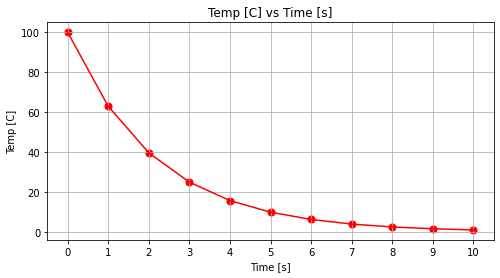

In [15]:
# Plot temps over time
_, ax = plt.subplots(1,1, figsize=(8, 4))
ax.plot(nt, temps, color='r')
ax.scatter(nt, temps, color='r', marker='o', s=50)
ax.set_xlabel('Time [s]'); ax.set_ylabel('Temp [C]');
ax.set_xticks(np.arange(11)); ax.set_yticks(np.arange(0, 120, 20))
ax.set_title('Temp [C] vs Time [s]'); ax.grid(True);


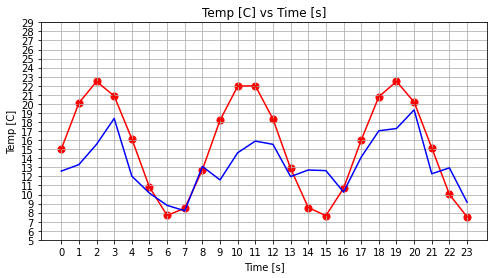

In [48]:
# Plot theta over varying time
# theta(fo) = (T[t]-Te) / (T[0]-Te)
# theta * (T[0]-Te) = T[t] - Te
# T[t] = [theta * (T[0]-Te)] + Te
# 4 hours = 24 ten minutes
dT = 7.5
nt = np.arange(24)
temps = np.sin(nt * 180.0 / np.pi) * dT + 15
tempsi = []
for temp_ext in temps:
    alpha = mat.diffusivity_coef(tc.k, tc.rho, tc.cp)
    _nt = np.arange(10)
    fo = mat.fourier_num(alpha, lc, _nt)
    bi = (tc.hc * (tc.vol / tc.area)) / tc.k
    # Get theta, dimensionless temp
    theta = heat.lumped_node(bi, fo)
    Ti = (theta * dT)
    Ti += np.random.normal(0, 5, _nt.shape) + (temp_ext + 10)
    #Ti = Ti_ - temp_ext
    #dT = (beta * (Ti))
    tempsi.append(Ti[-1] / 2.0)

_, ax = plt.subplots(1,1, figsize=(8, 4))
ax.plot(nt, temps, color='r')
ax.scatter(nt, temps, color='r', marker='o', s=50)
ax.plot(nt, tempsi, color='b');
ax.set_xlabel('Time [s]'); ax.set_ylabel('Temp [C]');
ax.set_xticks(nt); ax.set_yticks(np.arange(5, 30, 1))
ax.set_title('Temp [C] vs Time [s]'); ax.grid(True);
